In [1]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_msssim import MS_SSIM
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = "cpu"
# TODO: make sure to .to(device) the class later, and also set up gpu

# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0
# number of epochs
num_epochs = 3
# batch size for training
batch_size = 16
# height and width of input image
img_size = 64
# the alphabet characters
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# number of channels
nc0 = 1 * len(alphabet)
nc1 = 4 * len(alphabet)
nc2 = 8 * len(alphabet)
nc3 = 16 * len(alphabet)
# disciminator channels
dc0 = 1
dc1 = 8
dc2 = 16
dc3 = 32
# threshold
thresh = 0
# learning rate
lr = 0.002
# beta1 for Adam
beta1 = 0.5
# real label
real_label = 1.0
# fake label
fake_label = 0.0
# number of extra times to run the discriminator than the encdec per epoch
num_dis = 1
# coefficient of the discriminator loss in training
cof_dis = 7e-3
# number of patches to sample
num_patches = 3
# letter we use to generate all the other letters
base_letter = 'R'
# letter we are trying to generate
gen_letter = 'B'

In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
class FontDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.fontlist = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fontlist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {}
        for c in alphabet:
            path = os.path.join(self.root_dir, c, f'{idx}.npy')
            img = np.load(path)
            img = img[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]
            img = self.transform(img)
            sample[c] = img

        return sample

In [5]:
# From https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/3
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=3, padding=1):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=padding)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter

In [7]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.conv01 = nn.Conv2d(dc0, dc1, 3, padding=1)
        self.conv12 = nn.Conv2d(dc1, dc2, 3, padding=1)
        self.conv23 = nn.Conv2d(dc2, dc3, 3, padding=1)

        self.conv33_1 = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv33_2 = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv33_3 = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv33_4 = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv33_5 = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv33_6 = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv33_7 = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv33_8 = nn.Conv2d(dc3, dc3, 3, padding=1)
        
        
        self.conv32 = nn.Conv2d(dc3, nc0, 3, padding=1)
        
        self.conv0same_1 = nn.Conv2d(nc0, nc0, 3, padding=1)
        self.conv0same_2 = nn.Conv2d(nc0, nc0, 3, padding=1)

        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.threshold = nn.Threshold(thresh, 0)
        
        self.gaussian_filter = get_gaussian_kernel(kernel_size = 3, sigma=2, channels=nc0)
        
    def forward(self, x):
        x = self.conv01(x)
        x = self.leakyrelu(x)
        x = self.conv12(x)
        x = self.leakyrelu(x)
        x = self.conv23(x)
        x = self.leakyrelu(x)
        x, idx1 = self.pool(x)
        
        x = self.conv33_1(x)
        x = self.leakyrelu(x)
        x, idx2 = self.pool(x)
        
        x = self.conv33_4(x)
        x = self.leakyrelu(x)
        x, idx3 = self.pool(x)
        
        x = self.unpool(x, idx3)
        x = self.conv33_6(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx2)
        x = self.conv33_7(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx1)
        x = self.conv32(x)
        x = self.leakyrelu(x)
        
        x = self.gaussian_filter(x)
        x = self.conv0same_1(x)
        x = self.leakyrelu(x)
        
        x = self.tanh(x)
        
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv0 = nn.Conv2d(nc0, nc2, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2stri = nn.Conv2d(nc2, nc2, 4, stride=2, padding=1)
        self.conv2same = nn.Conv2d(nc2, nc2, 3, padding=1)
        self.conv3 = nn.Conv2d(nc2, nc3, 4, stride=2, padding=1)
        self.norm3 = nn.BatchNorm2d(nc3)
        self.conv3same = nn.Conv2d(nc3, nc3, 3, padding=1)
        self.conv3back = nn.Conv2d(nc3, nc2, 3, padding=1)
        self.conv0back = nn.Conv2d(nc2, nc0, 3, padding=1)
        self.flat = nn.Flatten(2)
        self.linear = nn.Linear(img_size//8 * img_size//8, 1)
        self.sigmoid = nn.Sigmoid()
        self.flat1 = nn.Flatten()
        
    def forward(self, input):
        # nc0 x img_size x img_size
        out = self.conv0(input)
        out = self.relu(out)
        
        # nc2 x img_size x img_size
        out = self.conv2stri(out)
        out = self.relu(out)
        
        # nc2 x img_size/2 x img_size/2
        out = self.conv2stri(out)
        out = self.relu(out)
        
        # nc2 x img_size/4 x img_size/4
        out = self.conv3(out)
        out = self.norm3(out)
        out = self.relu(out)
        
        # nc3 x img_size/8 x img_size/8
        out = self.conv3back(out)
        out = self.relu(out)
        
        # nc2 x img_size/8 x img_size/8
        out = self.conv0back(out)
        out = self.relu(out)
        
#         print(out.size())
        out = self.flat(out)
#         print('before linear', out.size())
        out = self.linear(out)
#         print(out.size())
        out = self.flat1(out)
        out = self.sigmoid(out)
#         print(out.size())
        
        return out

In [9]:
class LocalDiscriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            # 8 x img_size/4 x img_size/4
            nn.Flatten(),
            nn.Linear(nc2 * img_size // 4 * img_size // 4, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [10]:
def concat_tensors(data):
    tensor = None
    
    for c in alphabet:
        if tensor == None:
            tensor = data[c]
        else:
            tensor = torch.cat((tensor, data[c]), 1)
    
    return tensor

In [11]:
lossD_list = []
loss_disc_list = []
loss_l1_list = []
loss_ssim_list = []
loss_local_list = []

In [12]:
dataset = FontDataset(csv_file=fonts_csv, 
    root_dir=dataroot, 
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
#AddGaussianNoise(0., 0.05),
    ]))
testset_size = len(dataset) // 5 * 4
train_set, val_set = random_split(dataset, [testset_size, len(dataset) - testset_size], generator=torch.Generator().manual_seed(42))
train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)
val_data = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=workers)

In [17]:
def main():    
    encdec = EncoderDecoder()
    # use this line to continue training instead of starting a new one
#     encdec.load_state_dict(torch.load('encdec-Copy5.pt'))
    
    # use this if finetuning on the existing encdec
#     encdec = Finetune_EncDec(pretrained=encdec)
#     encdec.load_state_dict(torch.load('encdec-res.pt'))
    
    criterionED_l1 = nn.L1Loss()
    criterionED_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=nc0)
    optimizerED = optim.Adam(encdec.parameters(), lr=lr)

    disc = Discriminator()
    criterionD = nn.BCELoss()
    optimizerD = optim.Adam(disc.parameters(), lr=lr)
    
    # training loop
    for epoch in range(num_epochs):
        running_lossD = 0.0
        running_loss_disc = 0.0
        running_loss_l1 = 0.0
        running_loss_ssim = 0.0
        running_loss_local = 0.0
        
#         for it in range(num_dis):
#             for i, data in enumerate(train_data):
#                 train_batch = concat_tensors(data)
#                 disc.zero_grad()
                
#                 b_size = train_batch.size(0)
#                 c_size = train_batch.size(1)
#                 label = torch.full((b_size,c_size,), real_label, dtype=torch.float, device=device)
                
#                 outputD = disc(train_batch)
#                 lossD_real = criterionD(outputD, label)
#                 lossD_real.backward()

#                 # all fake batch
#                 outputED = encdec(data[base_letter])
#                 label.fill_(fake_label)
#                 outputD = disc(outputED.detach())
#                 lossD_fake = criterionD(outputD, label)
#                 lossD_fake.backward()

#                 lossD = lossD_real + lossD_fake
#                 optimizerD.step()
#         print('finished updating dis')
                
        for i, data in enumerate(train_data):
            train_batch = concat_tensors(data)
            ###########################
            # update disc
            ###########################
            disc.zero_grad()
            # all real batch
            b_size = train_batch.size(0)
            c_size = train_batch.size(1)
            label = torch.full((b_size,c_size,), real_label, dtype=torch.float, device=device)
            outputD = disc(train_batch)
            lossD_real = criterionD(outputD, label)
            lossD_real.backward()
            
            # all fake batch
            outputED = encdec(data[base_letter])
            
            label.fill_(fake_label)
            outputD = disc(outputED.detach())
            lossD_fake = criterionD(outputD, label)
            lossD_fake.backward()

            lossD = lossD_real + lossD_fake
            optimizerD.step()

            ###########################
            # update encdec
            ###########################
            encdec.zero_grad()
            # rerun disc
            label.fill_(real_label)
            outputD = disc(outputED)
            lossED_disc = criterionD(outputD, label)
            # run encdec
            lossED_l1 = criterionED_l1(outputED, train_batch)
            
            # calculate local loss
            lossED_local = 0.0
            for _ in range(num_patches):
                x = np.random.randint(16, 48)
                y = np.random.randint(16, 48)
                for j, c in enumerate(alphabet):
                    outputED_patch = outputED[:, j, x-8:x+8, y-8:y+8]
                    datac2_patch = data[c][:, 0, x-8:x+8, y-8:y+8]
                    outputED_patch = (outputED_patch + 1) / 2
                    datac2_patch = (datac2_patch + 1) / 2
                    lossED_local += criterionED_l1(outputED_patch, datac2_patch)
            
            outputED_norm = (outputED + 1) / 2
            train_norm = (train_batch + 1) / 2
            lossED_ssim = 1 - criterionED_ssim(outputED_norm, train_norm)

            lossED = cof_dis * lossED_disc + 0.16 * lossED_l1 + 0.84 * lossED_ssim + lossED_local/num_patches
            lossED.backward()
            optimizerED.step()
    
            running_lossD += lossD.item()
            running_loss_disc += lossED_disc.item()
            running_loss_l1 += lossED_l1.item()
            running_loss_ssim += lossED_ssim.item()
            running_loss_local += lossED_local.item()
            if i % 10 == 9:
                print(f"Epoch {epoch+1}, Iteration {i+1}, Loss D {running_lossD}, Loss Disc {running_loss_disc}, Loss L1 {running_loss_l1}, Loss SSIM {running_loss_ssim}, Loss Local {running_loss_local}")
                lossD_list.append(running_lossD)
                loss_disc_list.append(running_loss_disc)
                loss_l1_list.append(running_loss_l1)
                loss_ssim_list.append(running_loss_ssim)
                loss_local_list.append(running_loss_local)
                running_lossD = 0.0
                running_loss_disc = 0.0
                running_loss_l1 = 0.0
                running_loss_ssim = 0.0
                running_loss_local = 0.0
                
                fig = plt.figure(figsize=(8, 8))
                fig.add_subplot(1, 2, 1)
                plt.imshow(data['A'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                fig.add_subplot(1, 2, 2)
                plt.imshow(outputED[0,0].detach().numpy(), cmap='gray')
                plt.show()
    
                torch.save(encdec.state_dict(), 'encdec-finetune.pt')
    print("Done")

Epoch 1, Iteration 10, Loss D 13.73181140422821, Loss Disc 29.460815131664276, Loss L1 9.636042594909668, Loss SSIM 7.098335325717926, Loss Local 365.7603073120117


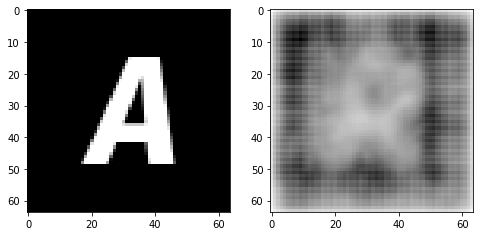

Epoch 1, Iteration 20, Loss D 8.612720489501953, Loss Disc 19.62094295024872, Loss L1 3.040997862815857, Loss SSIM 7.699941635131836, Loss Local 201.62800121307373


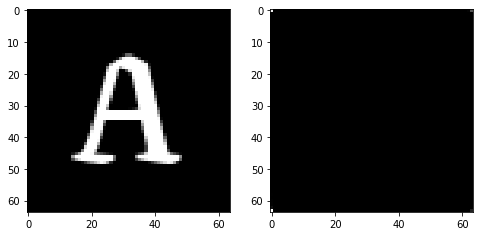

Epoch 1, Iteration 30, Loss D 6.865194082260132, Loss Disc 32.355822682380676, Loss L1 1.630130559206009, Loss SSIM 7.309423387050629, Loss Local 192.86880683898926


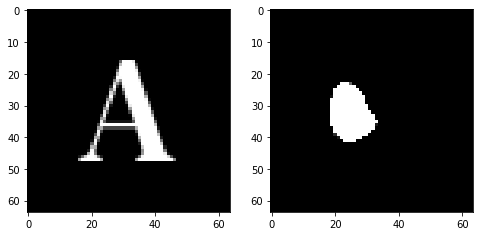

Epoch 1, Iteration 40, Loss D 5.242515325546265, Loss Disc 43.9246928691864, Loss L1 1.7163430899381638, Loss SSIM 6.538081169128418, Loss Local 186.57100772857666


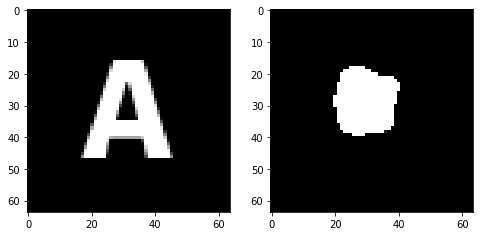

Epoch 1, Iteration 50, Loss D 4.9596832394599915, Loss Disc 59.818729400634766, Loss L1 1.6723720133304596, Loss SSIM 6.150628566741943, Loss Local 189.4666919708252


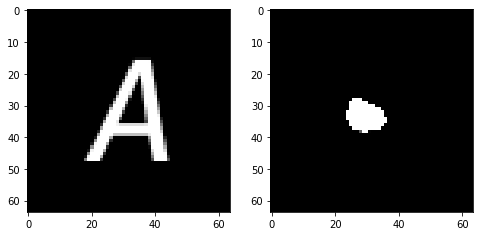

Epoch 1, Iteration 60, Loss D 4.836763858795166, Loss Disc 89.31671237945557, Loss L1 1.6321778446435928, Loss SSIM 5.999415636062622, Loss Local 187.47852897644043


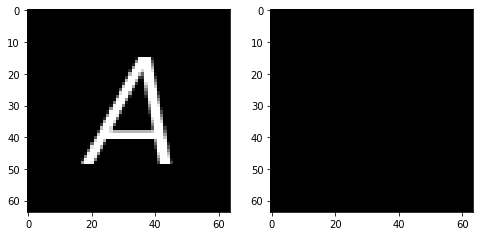

Epoch 1, Iteration 70, Loss D 4.826992511749268, Loss Disc 83.68893194198608, Loss L1 1.516980230808258, Loss SSIM 6.000100791454315, Loss Local 186.17493152618408


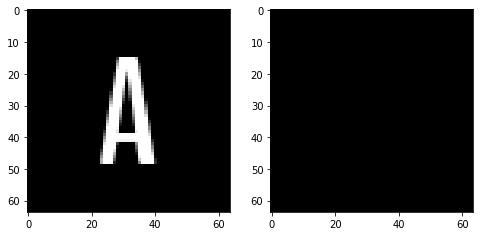

Epoch 1, Iteration 80, Loss D 4.372933745384216, Loss Disc 68.74916934967041, Loss L1 1.5924178212881088, Loss SSIM 5.987622380256653, Loss Local 173.79270267486572


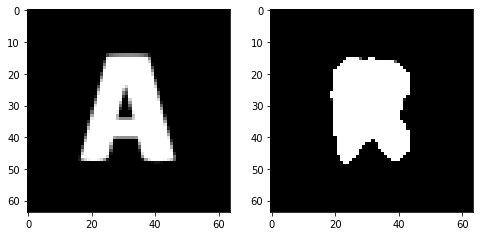

Epoch 1, Iteration 90, Loss D 4.28564926981926, Loss Disc 84.31834316253662, Loss L1 1.5632099658250809, Loss SSIM 5.006760358810425, Loss Local 205.97343635559082


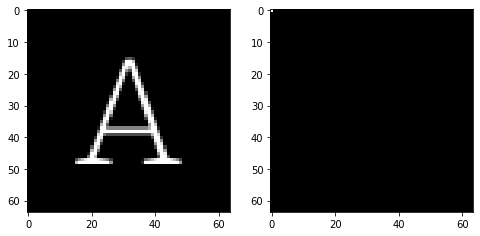

Epoch 1, Iteration 100, Loss D 4.351681560277939, Loss Disc 69.97283959388733, Loss L1 1.4848746955394745, Loss SSIM 4.91408908367157, Loss Local 174.86802673339844


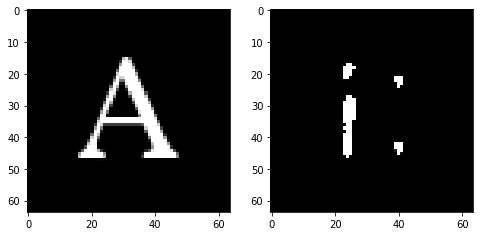

Epoch 1, Iteration 110, Loss D 4.276593178510666, Loss Disc 78.57405614852905, Loss L1 1.5073719769716263, Loss SSIM 4.178722321987152, Loss Local 155.39619541168213


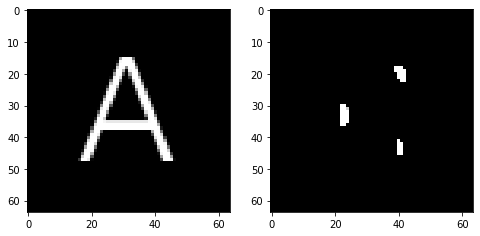

Epoch 1, Iteration 120, Loss D 4.2688358426094055, Loss Disc 75.43151330947876, Loss L1 1.4880316406488419, Loss SSIM 4.691770672798157, Loss Local 181.3593692779541


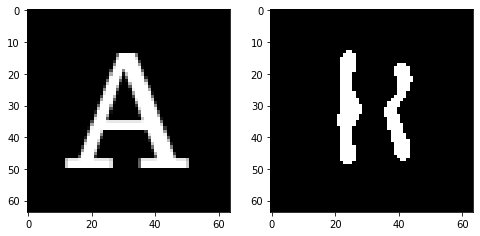

Epoch 1, Iteration 130, Loss D 4.270463436841965, Loss Disc 77.34000539779663, Loss L1 1.4906785935163498, Loss SSIM 4.483021080493927, Loss Local 153.71302127838135


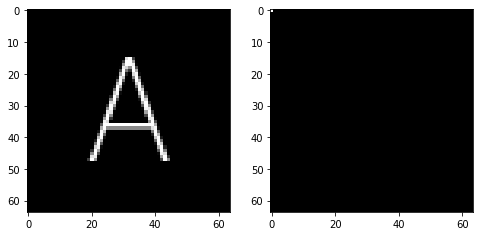

Epoch 1, Iteration 140, Loss D 4.266380071640015, Loss Disc 89.60198974609375, Loss L1 1.4762088358402252, Loss SSIM 4.3178664445877075, Loss Local 170.60680198669434


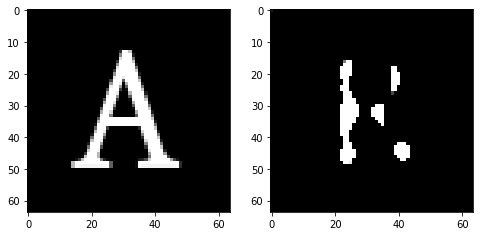

Epoch 1, Iteration 150, Loss D 4.270303785800934, Loss Disc 95.43385696411133, Loss L1 1.3938553482294083, Loss SSIM 4.798189103603363, Loss Local 163.88683128356934


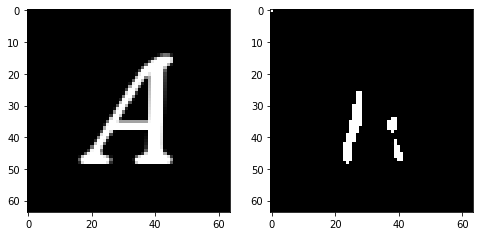

Epoch 1, Iteration 160, Loss D 4.266483664512634, Loss Disc 79.31798028945923, Loss L1 1.4979564994573593, Loss SSIM 4.3372586369514465, Loss Local 165.07124042510986


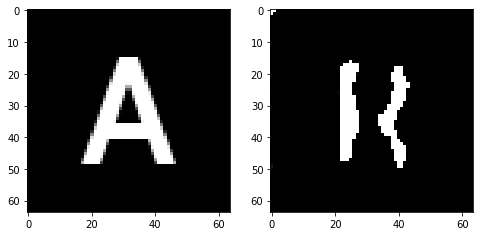

Epoch 1, Iteration 170, Loss D 4.26659432053566, Loss Disc 82.21008777618408, Loss L1 1.4639902859926224, Loss SSIM 4.687876880168915, Loss Local 167.47656154632568


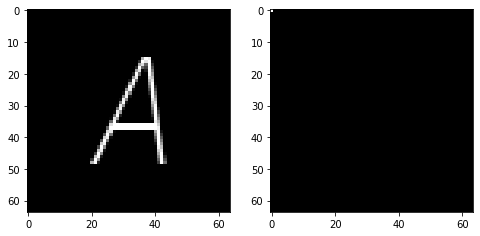

Epoch 1, Iteration 180, Loss D 4.282829076051712, Loss Disc 69.92547750473022, Loss L1 1.422337882220745, Loss SSIM 4.4186835289001465, Loss Local 172.413743019104


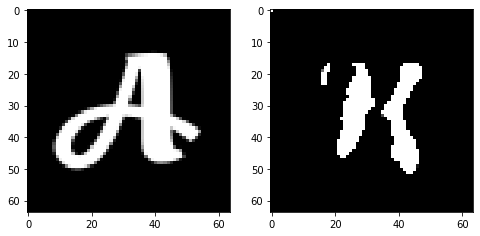

Epoch 1, Iteration 190, Loss D 4.266066998243332, Loss Disc 92.61607360839844, Loss L1 1.4302933663129807, Loss SSIM 4.5882408618927, Loss Local 156.18855381011963


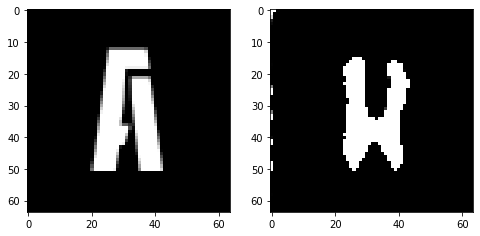

Epoch 2, Iteration 10, Loss D 4.266390413045883, Loss Disc 91.70293235778809, Loss L1 1.4936233311891556, Loss SSIM 4.43428361415863, Loss Local 169.79178142547607


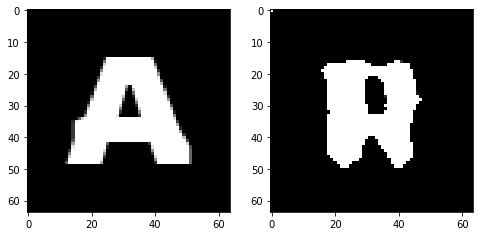

Epoch 2, Iteration 20, Loss D 4.2660839557647705, Loss Disc 92.1280927658081, Loss L1 1.4875431209802628, Loss SSIM 4.290198385715485, Loss Local 170.83839225769043


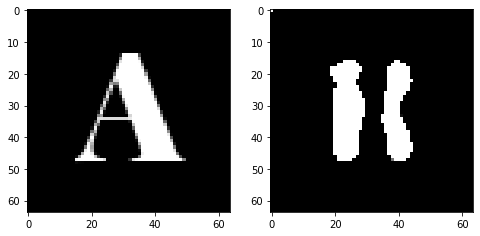

Epoch 2, Iteration 30, Loss D 4.2661184668540955, Loss Disc 96.46192264556885, Loss L1 1.3907263427972794, Loss SSIM 4.56811785697937, Loss Local 158.65556621551514


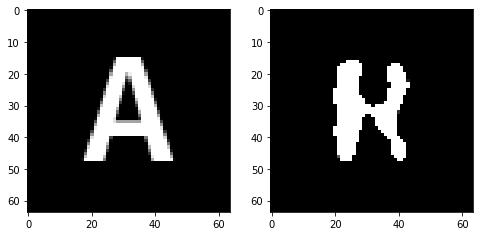

Epoch 2, Iteration 40, Loss D 4.26577952504158, Loss Disc 97.52496719360352, Loss L1 1.4453042298555374, Loss SSIM 4.572528064250946, Loss Local 160.60754489898682


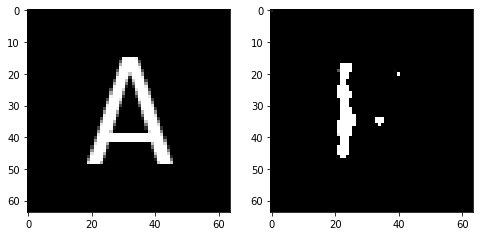

Epoch 2, Iteration 50, Loss D 4.2701700031757355, Loss Disc 92.05707263946533, Loss L1 1.4228777512907982, Loss SSIM 4.362607061862946, Loss Local 167.04136562347412


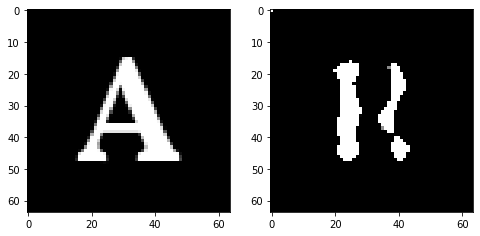

Epoch 2, Iteration 60, Loss D 4.267583578824997, Loss Disc 80.93222188949585, Loss L1 1.4813082963228226, Loss SSIM 4.75736677646637, Loss Local 158.1111307144165


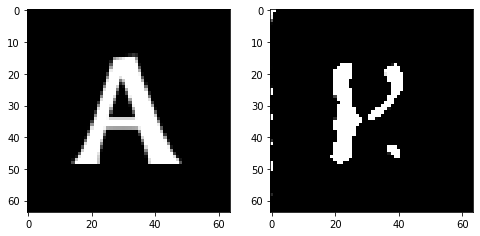

Epoch 2, Iteration 70, Loss D 4.266167163848877, Loss Disc 88.82854843139648, Loss L1 1.4202442467212677, Loss SSIM 4.543155252933502, Loss Local 155.20185565948486


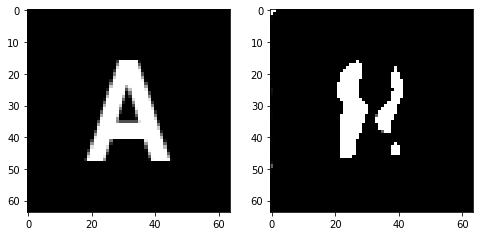

Epoch 2, Iteration 80, Loss D 4.265733003616333, Loss Disc 89.29133415222168, Loss L1 1.4435580372810364, Loss SSIM 4.1316946148872375, Loss Local 178.28304862976074


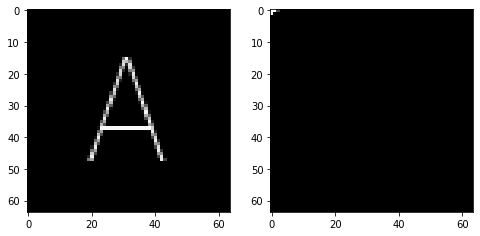

Epoch 2, Iteration 90, Loss D 4.265793472528458, Loss Disc 89.29549312591553, Loss L1 1.393348067998886, Loss SSIM 4.661529004573822, Loss Local 172.3768081665039


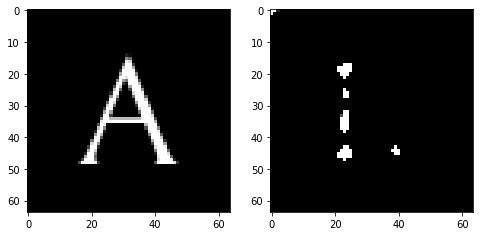

Epoch 2, Iteration 100, Loss D 4.265744656324387, Loss Disc 92.9475908279419, Loss L1 1.3899702578783035, Loss SSIM 4.522901713848114, Loss Local 144.30989170074463


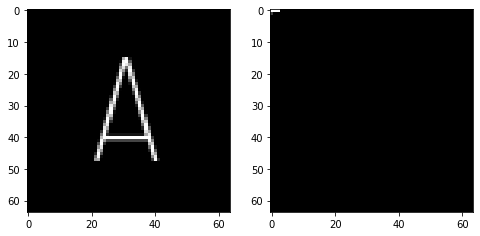

Epoch 2, Iteration 110, Loss D 4.2662665247917175, Loss Disc 91.98442935943604, Loss L1 1.467920869588852, Loss SSIM 4.026701271533966, Loss Local 161.39364337921143


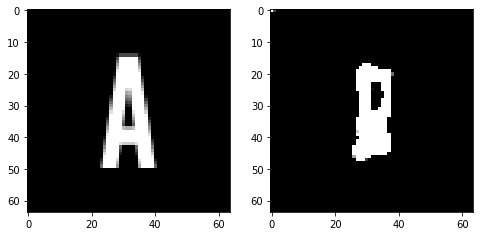

Epoch 2, Iteration 120, Loss D 4.265927851200104, Loss Disc 90.28613567352295, Loss L1 1.4025104492902756, Loss SSIM 4.14190286397934, Loss Local 170.99449634552002


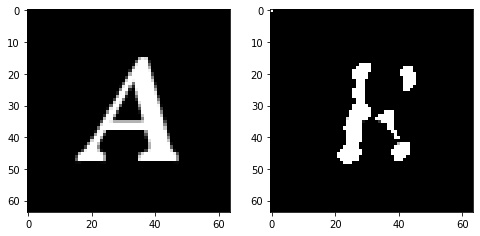

Epoch 2, Iteration 130, Loss D 4.2658326625823975, Loss Disc 87.8370304107666, Loss L1 1.4051098823547363, Loss SSIM 4.189459323883057, Loss Local 152.16053676605225


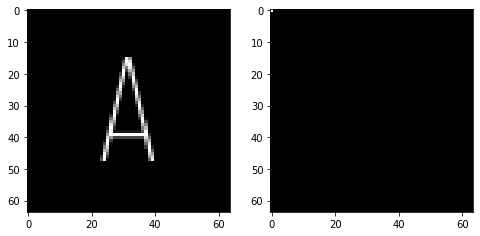

Epoch 2, Iteration 140, Loss D 4.265861988067627, Loss Disc 82.7686505317688, Loss L1 1.4968952685594559, Loss SSIM 3.6398499608039856, Loss Local 177.1631898880005


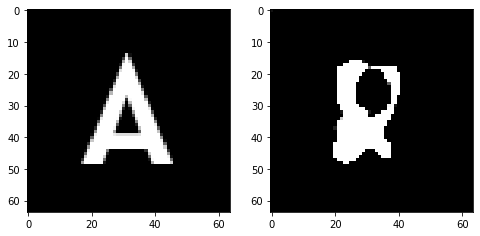

Epoch 2, Iteration 150, Loss D 4.265667676925659, Loss Disc 91.89157390594482, Loss L1 1.4209743812680244, Loss SSIM 4.222963392734528, Loss Local 170.02050018310547


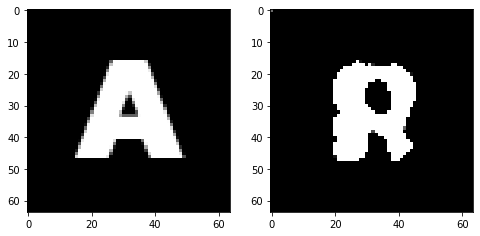

Epoch 2, Iteration 160, Loss D 4.265625596046448, Loss Disc 96.49921131134033, Loss L1 1.3846082016825676, Loss SSIM 4.547423303127289, Loss Local 159.86556434631348


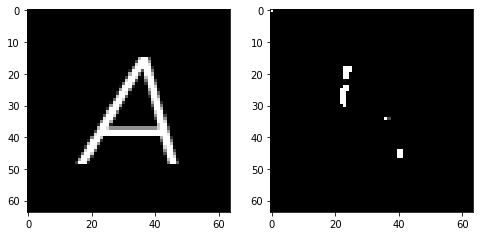

Epoch 2, Iteration 170, Loss D 4.265823125839233, Loss Disc 87.14098167419434, Loss L1 1.4191036522388458, Loss SSIM 4.10685932636261, Loss Local 169.50531387329102


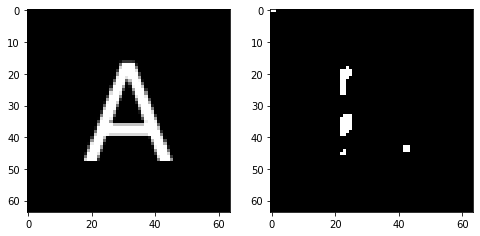

Epoch 2, Iteration 180, Loss D 4.265920728445053, Loss Disc 86.02043676376343, Loss L1 1.4234108179807663, Loss SSIM 3.844482898712158, Loss Local 158.24682140350342


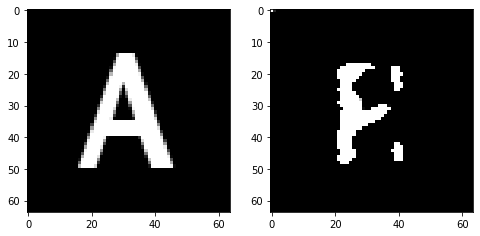

Epoch 2, Iteration 190, Loss D 4.2657462656497955, Loss Disc 89.36266326904297, Loss L1 1.3435974046587944, Loss SSIM 3.9832473397254944, Loss Local 154.21563625335693


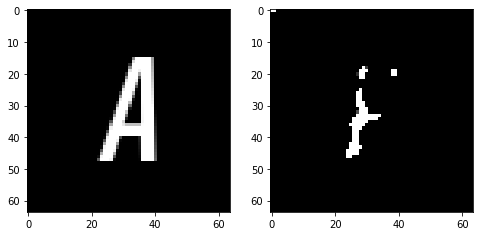

Epoch 3, Iteration 10, Loss D 4.266006946563721, Loss Disc 83.3595519065857, Loss L1 1.3949476182460785, Loss SSIM 3.9319546818733215, Loss Local 159.23673820495605


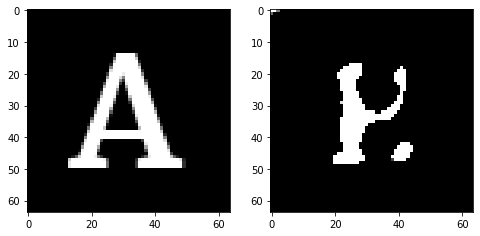

Epoch 3, Iteration 20, Loss D 4.266779780387878, Loss Disc 84.6695728302002, Loss L1 1.351026564836502, Loss SSIM 4.012096703052521, Loss Local 144.96882152557373


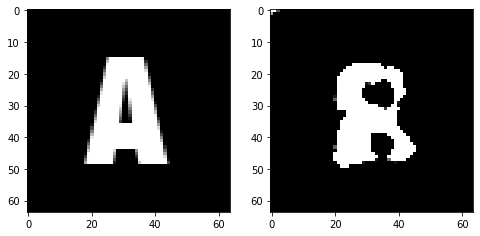

Epoch 3, Iteration 30, Loss D 4.266486018896103, Loss Disc 88.61494159698486, Loss L1 1.4046388566493988, Loss SSIM 3.824652314186096, Loss Local 144.43348693847656


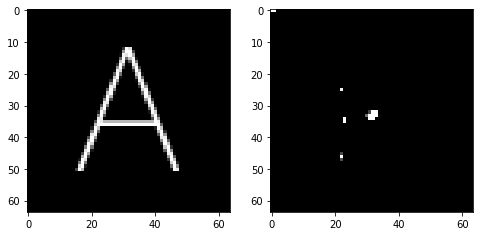

Epoch 3, Iteration 40, Loss D 4.268299162387848, Loss Disc 88.13348579406738, Loss L1 1.380445383489132, Loss SSIM 3.90033620595932, Loss Local 149.20597457885742


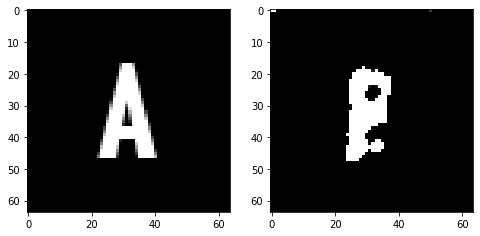

Epoch 3, Iteration 50, Loss D 4.271574676036835, Loss Disc 85.72869539260864, Loss L1 1.3478157371282578, Loss SSIM 3.736538887023926, Loss Local 146.34474658966064


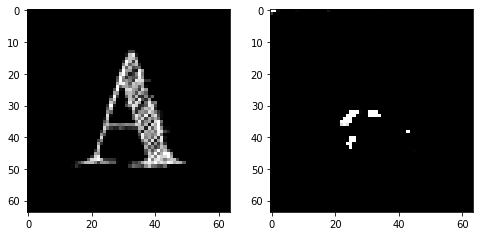

Epoch 3, Iteration 60, Loss D 14.325419902801514, Loss Disc 30.582470536231995, Loss L1 1.348391093313694, Loss SSIM 3.8661165833473206, Loss Local 159.75811767578125


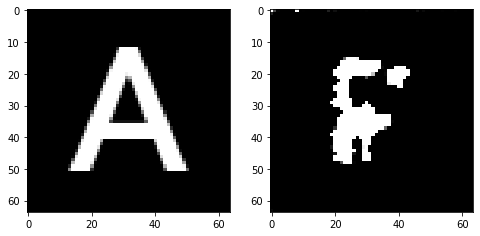

Epoch 3, Iteration 70, Loss D 13.863052248954773, Loss Disc 6.966177523136139, Loss L1 1.3436035886406898, Loss SSIM 3.3809563517570496, Loss Local 145.48361206054688


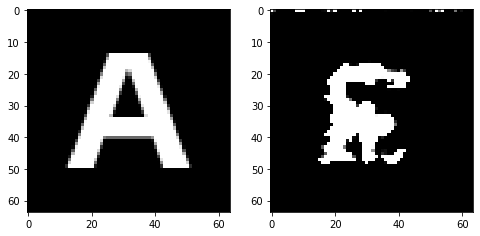

Epoch 3, Iteration 80, Loss D 13.863101720809937, Loss Disc 6.9712815284729, Loss L1 1.34746702760458, Loss SSIM 3.8416647911071777, Loss Local 160.6803903579712


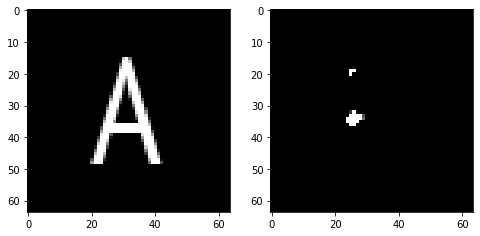

Epoch 3, Iteration 90, Loss D 13.863077998161316, Loss Disc 6.96765273809433, Loss L1 1.3143479153513908, Loss SSIM 3.5849427580833435, Loss Local 136.6661958694458


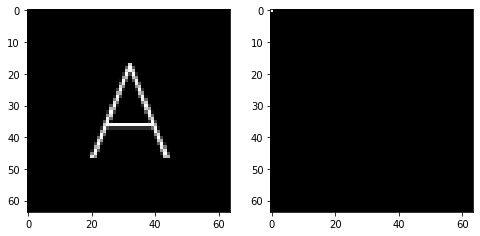

Epoch 3, Iteration 100, Loss D 13.863117098808289, Loss Disc 6.960581481456757, Loss L1 1.3427179753780365, Loss SSIM 3.3661901354789734, Loss Local 144.09007358551025


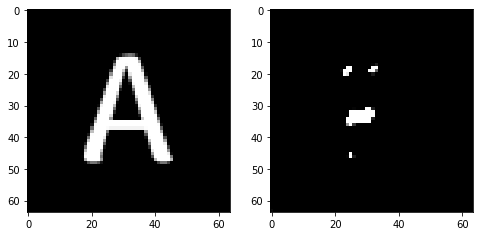

Epoch 3, Iteration 110, Loss D 13.851351857185364, Loss Disc 6.937832415103912, Loss L1 1.2889680862426758, Loss SSIM 3.515609085559845, Loss Local 143.68236637115479


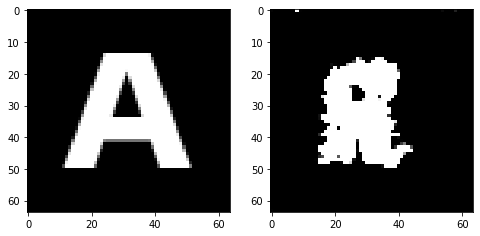

Epoch 3, Iteration 120, Loss D 13.808399677276611, Loss Disc 6.927558720111847, Loss L1 1.2422913163900375, Loss SSIM 3.3001415133476257, Loss Local 140.29222297668457


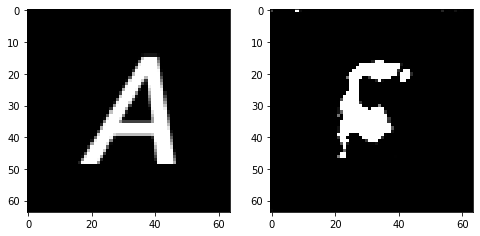

Epoch 3, Iteration 130, Loss D 13.825163722038269, Loss Disc 6.918707191944122, Loss L1 1.254867285490036, Loss SSIM 3.331852972507477, Loss Local 136.62914657592773


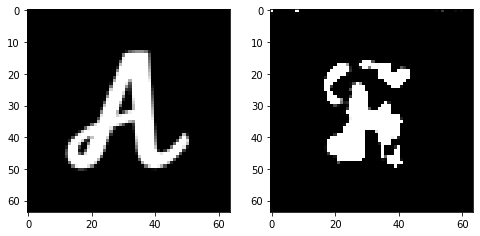

Epoch 3, Iteration 140, Loss D 13.801035404205322, Loss Disc 6.944830596446991, Loss L1 1.2568388283252716, Loss SSIM 2.8453709483146667, Loss Local 136.49581241607666


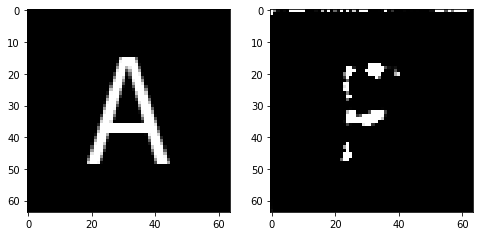

Epoch 3, Iteration 150, Loss D 13.884596705436707, Loss Disc 6.97881805896759, Loss L1 1.2519796639680862, Loss SSIM 3.379323184490204, Loss Local 146.94373893737793


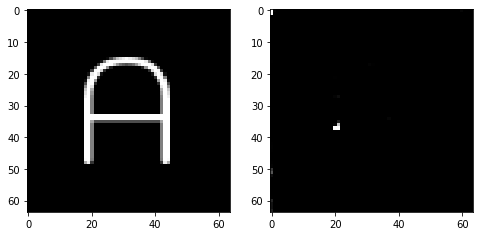

Epoch 3, Iteration 160, Loss D 13.863279461860657, Loss Disc 6.988986611366272, Loss L1 1.1788452938199043, Loss SSIM 3.032536208629608, Loss Local 129.96591091156006


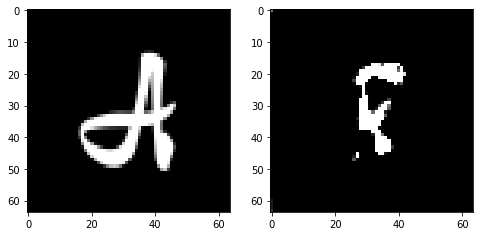

Epoch 3, Iteration 170, Loss D 13.863189935684204, Loss Disc 6.980057597160339, Loss L1 1.2309438213706017, Loss SSIM 2.87774521112442, Loss Local 125.88589096069336


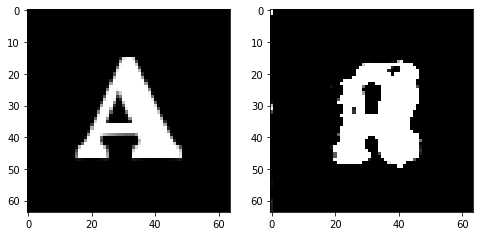

Epoch 3, Iteration 180, Loss D 13.863096594810486, Loss Disc 6.969528019428253, Loss L1 1.1669474318623543, Loss SSIM 2.9112071990966797, Loss Local 136.44478130340576


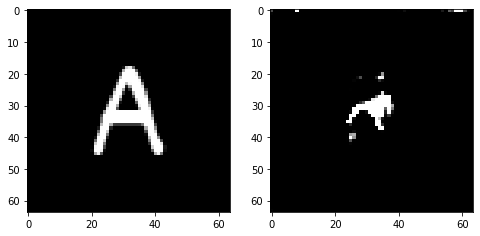

Epoch 3, Iteration 190, Loss D 13.863030672073364, Loss Disc 6.959973633289337, Loss L1 1.1927624195814133, Loss SSIM 2.767564296722412, Loss Local 126.72168350219727


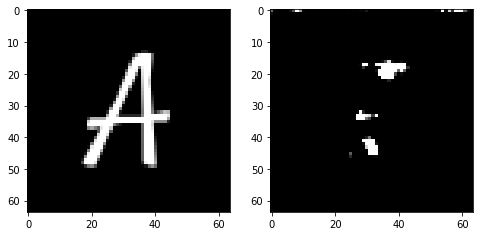

Done


In [18]:
main()

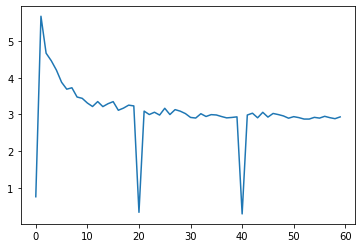

In [174]:
# plot losses
plt.plot(loss_ssim_list)
plt.show()

In [182]:
# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0

# model that we are evaluating
model_file = 'encdec.pt'

In [183]:
encdec = EncoderDecoder()
encdec.load_state_dict(torch.load(model_file))

# encdec = Finetune_EncDec(pretrained=encdec)
# encdec.load_state_dict(torch.load('encdec-finetune.pt'))

encdec.eval()

EncoderDecoder(
  (conv01): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv23): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv33): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(32, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0same): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (relu): ReLU(inplace=True)
  (leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (threshold): Threshold(threshold=0, value=0)
  (gaussian_filter): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=26, bias=False)
)

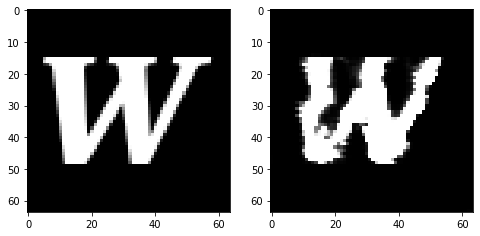

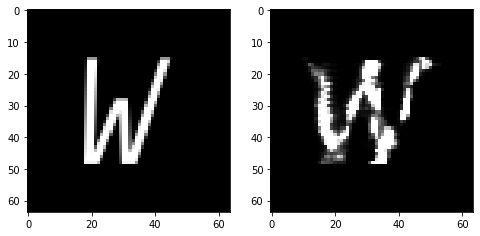

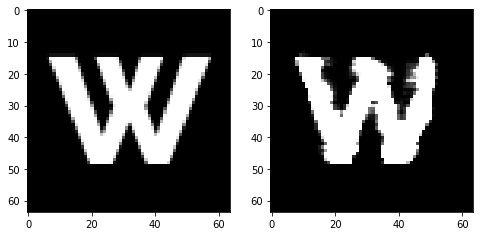

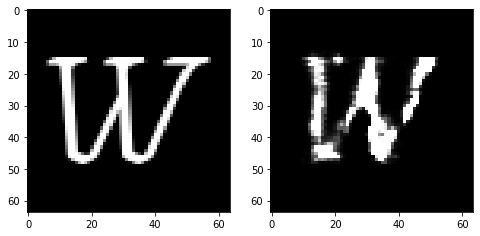

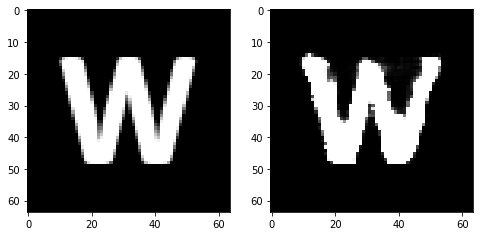

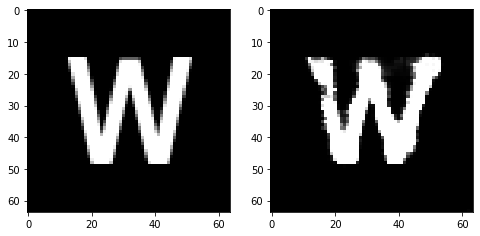

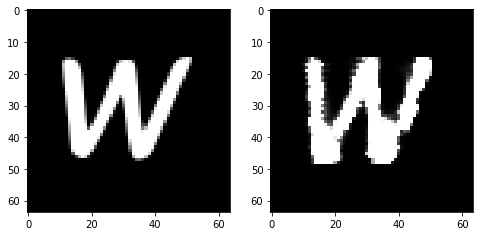

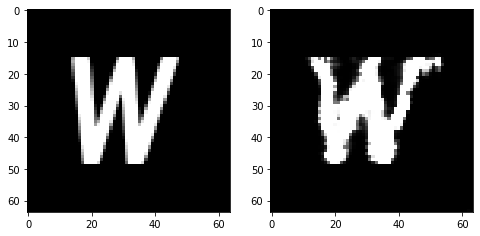

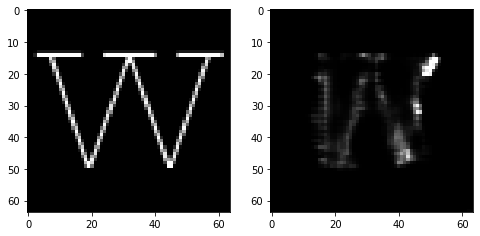

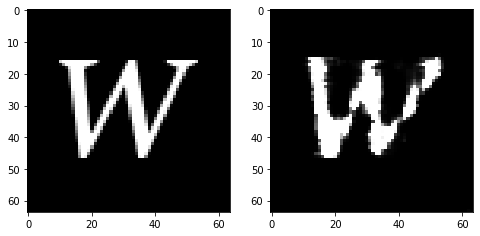

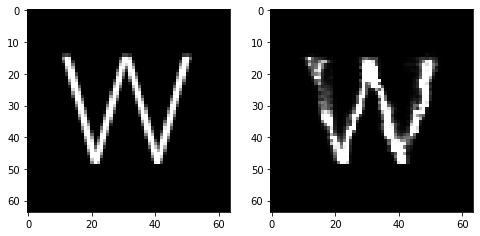

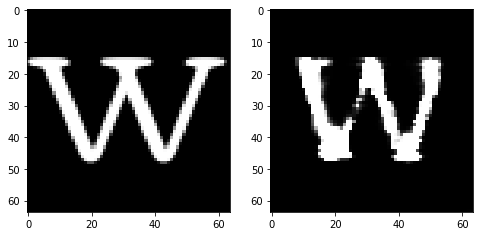

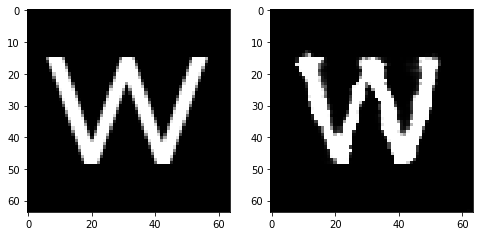

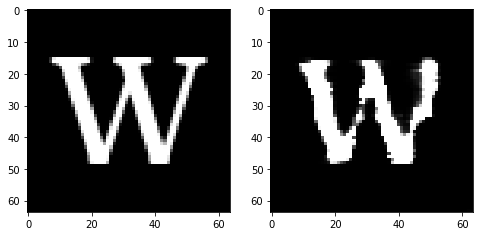

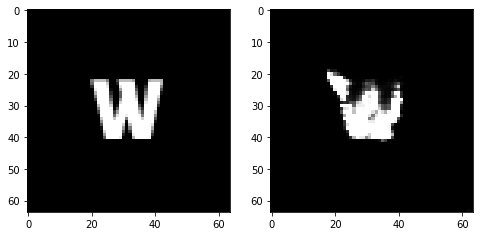

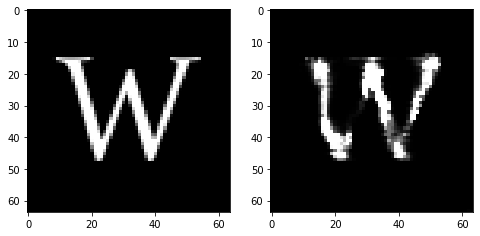

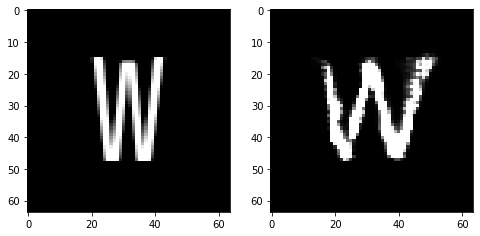

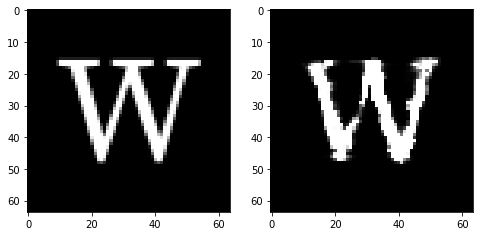

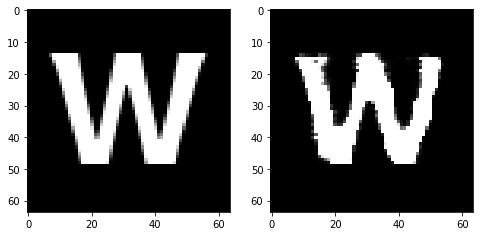

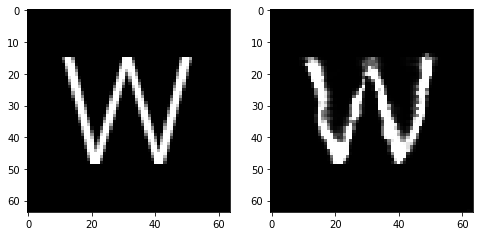

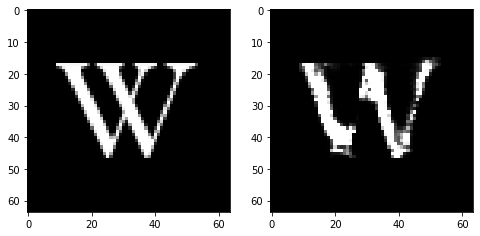

In [184]:
#look at result and ground truth side by side
for i, data in enumerate(val_data):
    if i > 20:
        break
    fig_letter = 'W'
    fig = plt.figure(figsize=(8, 8))
    output = encdec(data['R'])
    fig.add_subplot(1, 2, 1)
    plt.imshow(data[fig_letter][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(output[0,ord(fig_letter) - ord('A')].detach().numpy(), cmap='gray')
    plt.show()

In [180]:
#set up for evaluation
criterion_L1 = nn.L1Loss()
criterion_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=1)

In [185]:
#evaluate accuracy using L1 loss
val_len = len(val_data)
sum_L1 = torch.zeros(len(alphabet))
sum_ssim = torch.zeros(len(alphabet))
for i, data in enumerate(val_data):
    output = encdec(data['R'])
    
    for c in alphabet:
        truth = data[c].reshape(1, 1, img_size, img_size)
        index = ord(c) - ord('A')
        generated = output[0, index].reshape(1,1, img_size, img_size)
        
        loss_L1 = criterion_L1(truth, generated)

        output_norm = (generated + 1) / 2
        truth_norm = (truth+1) / 2
        
        loss_ssim = 1 - criterion_ssim(output_norm, truth_norm)
        
        sum_L1[index] += loss_L1
        sum_ssim[index] += loss_ssim
    
print(f'L1: {sum_L1/val_len}, \nssim: {sum_ssim/val_len}')

L1: tensor([0.0773, 0.0581, 0.0595, 0.0605, 0.0522, 0.0461, 0.0792, 0.0643, 0.0322,
        0.0810, 0.0674, 0.0406, 0.1411, 0.0796, 0.0679, 0.0472, 0.1247, 0.0305,
        0.0617, 0.0410, 0.0642, 0.0635, 0.1480, 0.0599, 0.0570, 0.0501],
       grad_fn=<DivBackward0>), 
ssim: tensor([0.1001, 0.0640, 0.0880, 0.0693, 0.0747, 0.0702, 0.1031, 0.0816, 0.0628,
        0.1560, 0.0814, 0.0674, 0.1820, 0.0946, 0.0779, 0.0559, 0.1643, 0.0236,
        0.0859, 0.0672, 0.0852, 0.0860, 0.1969, 0.0742, 0.0845, 0.0682],
       grad_fn=<DivBackward0>)
